In [322]:
import pytraj as pt
import pytraj.utils.progress
import numpy as np
import scipy as sp
from scipy import signal
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import collections
import sys
import gc
import os
import sklearn as skl
from sklearn import decomposition
from sklearn import metrics
from sklearn import discriminant_analysis
from sklearn import pipeline
import tqdm
import nglview as nv
import ipywidgets
import copy
import cPickle

In [8]:
def loadDataFrameChunks(filePathBase,nChunks):
    dataTables=[]
    chunkStr='chunk_%s0%gg'%('%',int(np.floor(np.log10(nChunks)))+1)
    with tqdm.tqdm_notebook(np.arange(nChunks)) as loadBar:
        loadBar.set_description('Loading Data Frame Chunks')
        for iChunk in loadBar:
            dataFilePath='.'.join([filePathBase,chunkStr%iChunk,'csv'])
            dataTables.append(
                pd.read_csv(dataFilePath))
            gc.collect()
    return pd.concat(dataTables)

Lets find out how many chunks we need to load the joint data table

our data path is separated by '/' for directories

then '.' for file name components

then finally 'chunk_#'

the bash 'awk' utility should make short work of this...

In [9]:
!ls dataFiles/phiPsiTables/joint* | awk -F / '{print $NF}' | awk -F . '{print $(NF-1)}' | awk -F _ '{print $NF}' | tail -n 1

183


Since numbering starts at 0, there are a total of 184 chunks.

Each chunk is about 20M so this data takes up about 3.68G on disk.

When loaded into memory, this typically takes a good deal less space.

That should come out to around 1-2 G, which should all fit into memory at once, so lets give it a shot.

In [10]:
phiPsiDataDir='dataFiles/phiPsiTables'
phiPsiDataFileNameBase='joint.phi_psi_table'
phiPsiDataFilePathBase='/'.join([phiPsiDataDir,phiPsiDataFileNameBase])
nChunks=184
phiPsiTable=loadDataFrameChunks(phiPsiDataFilePathBase,nChunks)
phiPsiTable.head()

,System,Replica,Frame,psi_1,phi_2,psi_2,phi_3,psi_3,phi_4,psi_4,...,psi_4249,phi_4250,psi_4250,phi_4251,psi_4251,phi_4252,psi_4252,phi_4253,psi_4253,phi_4254
0,dooku1,replica_01,0,-74.643320,-86.949338,-11.948323,-51.579987,-48.787006,-66.901503,-61.455534,...,-55.481505,-36.504965,-56.287306,-67.778789,-46.117579,-52.189006,-43.945274,-74.924682,-66.217169,-103.713370
1,dooku1,replica_01,1,-58.206487,-60.224124,-27.677685,-35.367547,-42.186970,-57.895262,-45.374696,...,-53.570610,-58.357301,-46.528847,-60.128773,-45.456034,-55.007758,-57.293026,-69.724111,-64.112041,-110.977059
2,dooku1,replica_01,2,-76.499336,-67.394422,-31.102480,-54.670125,-56.224834,-73.960017,-32.896219,...,-82.908174,-32.453594,-50.303473,-74.339279,-31.088671,-84.192947,-47.148351,-50.825231,-61.616256,-103.934319
3,dooku1,replica_01,3,-73.010182,-64.927090,-5.299644,-69.247831,-53.201987,-62.592633,-48.660764,...,-51.785226,-43.079281,-60.937571,-62.083156,-43.464471,-59.039981,-36.750100,-74.121166,-61.006412,-111.332966
4,dooku1,replica_01,4,-42.996691,-54.061560,-48.147955,-58.139673,-39.149352,-61.645541,-50.066992,...,-50.549270,-45.642865,-54.743022,-66.699957,-41.649581,-44.026032,-71.837834,-69.414632,-60.253487,-108.970518


Since this all fits into memory at once, we should be able to run PCA and LDA without needing
to resort to incremental techniques.

before proceeding, we should consider how we will validate the method.

We have four replicas for each system to use. Each replica can be treated as an
indepentent realization of the effect of a particular ligand (or lack there of)
on the protein.

We would like to make sure that our method is transferable, or more specifically,
the method should work well if one were to run a new replica of one of our simulations.

To that end, we will employ cross-validation methods.

In particular 'leave one group out'... or in this case, one system-replica pair combination.

E.g. since we have 3 systems with 4 replicas each, there are $4^3=64$ possible combinations.
[(dooku1-replica_00, yoda0-replica_00, yoda1-replica_00),...]

as we parameterize / train our model we will leave one out these 64 combinations out of our
training set and reserve it to test the model.
We then repeat this until we have tried each of the 64 combinations as a test set.

The sci kit learn package contains a 'LeaveOneGroupOut' method that does something similar,
however, it would only be able to yield 4 distinct combinations since, for instance,
replica_00 for dooku1 would be considered in the same 'group' as replica_00 of yoda0...
we want to treat them as distinct. E.g. we should be able to reserve
dook1.replica_00,yoda1.replica_01, and yoda0.replica_02 as a testing set and keep all other
trajectories for training.

Below we define a method to do just that.

In [148]:
labelDat=phiPsiTable['System']
repDat=phiPsiTable['Replica']
keyLabels=np.array(map(lambda x,y: '.'.join([x,y]),
              labelDat,repDat))
phiPsiDat=phiPsiTable[phiPsiTable.columns[3:]]

In [164]:
def stratifiedReplicaSplit(sysLabels,repLabels,nSplits):
    sampleLabels=map(lambda x,y: '.'.join([str(x),str(y)]),
                     sysLabels,repLabels)
    nSysLabels=len(np.unique(sysLabels))
    nRepLabels=len(np.unique(repLabels))
    
    outInds=[]

    sysTypes=np.sort(np.unique(sysLabels))
    repTypes=np.sort(np.unique(repLabels))
    #generate a list of all possible combinations for having a single
    #rep from each system.
    #we will shamelessly hack np.meshgrid to achieve this.
    #we then sample nSplits entries from this list (without replacement)
    tempRepSets=[np.arange(nRepLabels)]*nSysLabels
    comboSetGrids=np.array([np.array(tempGrid.flat) for tempGrid in np.meshgrid(*tempRepSets)])
    #we can now generate a unique split by sampling from the total set of all
    #possible combo sets (without replacement)
    comboInds=np.random.choice(comboSetGrids.shape[1],nSplits,replace=False)
    combosArray=comboSetGrids[:,comboInds].T
    #print 'sysTypes',
    #print sysTypes
    #print 'repTypes',
    #print repTypes
    #print combosArray
    #print 'sample labels'
    #print sampleLabels
    for iSplit in np.arange(nSplits):
        comboSet=combosArray[iSplit].flatten()
        #print comboSet
        outInds.append(
            [np.argwhere(
                np.product(
                    [map(lambda x: x!='%s.%s'%(
                                sysTypes[iEntry],
                                repTypes[entry]),
                           sampleLabels) \
                             for iEntry,entry in enumerate(comboSet)],
                    axis=0)).flatten(),
            np.argwhere(
                np.sum(
                    [map(lambda x: x=='%s.%s'%(
                                sysTypes[iEntry],
                                repTypes[entry]),
                           sampleLabels) \
                             for iEntry,entry in enumerate(comboSet)],
                    axis=0)>0).flatten()])
    return outInds

In [167]:
cvSplitter=stratifiedReplicaSplit
iSplit=0
outInds=cvSplitter(labelDat,repDat,64)
for train_indices, test_indices in outInds:
    print '--- split %g ---'%iSplit
    print 'TRAIN:'
    for sample in np.array([np.unique(keyLabels[train_indices],return_counts=True)[0],
           np.unique(keyLabels[train_indices],return_counts=True)[1]]).T:
        print sample
    
    print 'TEST:'
    for sample in np.array([np.unique(keyLabels[test_indices],return_counts=True)[0],
           np.unique(keyLabels[test_indices],return_counts=True)[1]]).T:
        print sample
    
    iSplit=iSplit+1

--- split 0 ---
TRAIN:
['dooku1.replica_00' '2001']
['dooku1.replica_01' '2001']
['dooku1.replica_02' '2001']
['yoda0.replica_01' '1980']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_01' '928']
['yoda1.replica_02' '2001']
['yoda1.replica_03' '2001']
TEST:
['dooku1.replica_03' '2001']
['yoda0.replica_00' '2001']
['yoda1.replica_00' '2001']
--- split 1 ---
TRAIN:
['dooku1.replica_00' '2001']
['dooku1.replica_01' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_00' '2001']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_00' '2001']
['yoda1.replica_02' '2001']
['yoda1.replica_03' '2001']
TEST:
['dooku1.replica_02' '2001']
['yoda0.replica_01' '1980']
['yoda1.replica_01' '928']
--- split 2 ---
TRAIN:
['dooku1.replica_00' '2001']
['dooku1.replica_01' '2001']
['dooku1.replica_02' '2001']
['yoda0.replica_00' '2001']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_00' '2001']
['yoda1.replica_01' '928']
['yoda1.replica

['dooku1.replica_01' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_03' '2001']
--- split 29 ---
TRAIN:
['dooku1.replica_01' '2001']
['dooku1.replica_02' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_00' '2001']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_00' '2001']
['yoda1.replica_02' '2001']
['yoda1.replica_03' '2001']
TEST:
['dooku1.replica_00' '2001']
['yoda0.replica_01' '1980']
['yoda1.replica_01' '928']
--- split 30 ---
TRAIN:
['dooku1.replica_00' '2001']
['dooku1.replica_01' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_01' '1980']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_01' '928']
['yoda1.replica_02' '2001']
['yoda1.replica_03' '2001']
TEST:
['dooku1.replica_02' '2001']
['yoda0.replica_00' '2001']
['yoda1.replica_00' '2001']
--- split 31 ---
TRAIN:
['dooku1.replica_01' '2001']
['dooku1.replica_02' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_01' '1980']
['yoda0.replica_02' '2001']
['yoda0.re

['dooku1.replica_00' '2001']
['dooku1.replica_01' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_01' '1980']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_00' '2001']
['yoda1.replica_02' '2001']
['yoda1.replica_03' '2001']
TEST:
['dooku1.replica_02' '2001']
['yoda0.replica_00' '2001']
['yoda1.replica_01' '928']
--- split 58 ---
TRAIN:
['dooku1.replica_00' '2001']
['dooku1.replica_02' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_00' '2001']
['yoda0.replica_01' '1980']
['yoda0.replica_03' '1980']
['yoda1.replica_00' '2001']
['yoda1.replica_01' '928']
['yoda1.replica_02' '2001']
TEST:
['dooku1.replica_01' '2001']
['yoda0.replica_02' '2001']
['yoda1.replica_03' '2001']
--- split 59 ---
TRAIN:
['dooku1.replica_00' '2001']
['dooku1.replica_02' '2001']
['dooku1.replica_03' '2001']
['yoda0.replica_00' '2001']
['yoda0.replica_02' '2001']
['yoda0.replica_03' '1980']
['yoda1.replica_01' '928']
['yoda1.replica_02' '2001']
['yoda1.replica_03' '2001']
TEST:
['

We can now begin constructing a pipeline for our method.
Our goal is to identify residues with phi/psi angles that differ significantly from between
ligand simulations.

We would also like to see if we can identify unique 'states' (i.e. regions of phi-psi phase space)
that can help differentiate the effects of each ligand (or lack thereof).

Currently, we have over 8000 individual phi / psi angles to consider... this is a very high
dimensional space to study.

Principal component analyisis will be used here to help identify combinations of these phi-psi angles
that describe the different conformations observed, maximizing the amount of variation that each subsequent
mode describes.

From there, linear discriminant analysis will be employed to allow us to use this PCA data to classify a given trajectory frame. E.g. if we are given a set of phi-psi PC modes, we want to be able to predict which system that frame would most likely have come from.

If this is successful, we can then examine the coefficients attained from LDA to predict which modes... and correspondingly, which phi or psi angles were the most useful in distinguishing frames from one ligand simulation from the others.

To start, lets have a look at how this does on one of our train/test sets from above.

We will run both the training and testing through PCA followed by LDA.
To evaluate how well the different systemts are being clustered we will use
the reciprocal of the Davies-Bouldin score metric, which is essentially a measure
of intra-cluster deviation divided by inter-cluster centeroid distance.
We use the reciprocal so that a high score corresponds to better separation.

In [172]:
train_indices,test_indices=outInds[0]
trainData=np.array(phiPsiDat)[train_indices]
trainLabels=np.array(labelDat)[train_indices]
testData=np.array(phiPsiDat)[test_indices]
testLabels=np.array(labelDat)[test_indices]

PCAob=skl.decomposition.PCA(n_components=200)
LDAob=skl.discriminant_analysis.LinearDiscriminantAnalysis()
scoreFun=lambda X,y: 1./skl.metrics.davies_bouldin_score(X,y)

PCAtrain=PCAob.fit_transform(trainData)
LDAtrain=LDAob.fit_transform(PCAtrain,trainLabels)

print "PCA Train Score: %.3f"%scoreFun(PCAtrain,trainLabels)
print "LDA Train Score: %.3f"%scoreFun(LDAtrain,trainLabels)

PCAtest=PCAob.transform(testData)
LDAtest=LDAob.transform(PCAtest)

print "PCA Test Score: %.3f"%scoreFun(PCAtest,testLabels)
print "LDA Test Score: %.3f"%scoreFun(LDAtest,testLabels)


PCA Train Score: 0.294
LDA Train Score: 6.287
PCA Test Score: 0.330
LDA Test Score: 0.933


This result is quite interesting. It appears that LDA does indeed improve
cluster separation in both training and testing. Note that the testing set
is subjected to the PCA-LDA model that was fitted to the training data.
Since we were careful to set aside all data from the replicas used for testing,
these two should be relatively independent, or at the very least, can serve
as a gauge for how well the model would perform if someone were to run a brand
new replica for each system and apply this model.

With all that said, the PCA-LDA model performs significantly poorer on the testing
set than it did on the training set over which it was parameterized.
This may be a sign that we are over / under fitting our model, which we will address shortly.

For now, lets have a look at what our model yielded visually. Fortunately,
the combined PCA-LDA model yields a transformed feature set with exactly 2 dimensions.
This is excellent because we can then view clusters in that transformed space directly
as a 2D scatter plot.

dooku1
yoda0
yoda1


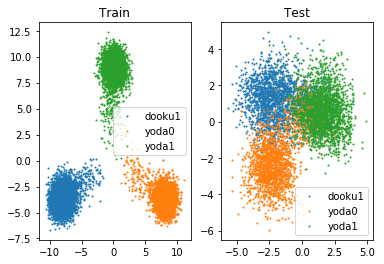

In [181]:
fig,axs=plt.subplots(1,2)

labelTypes=np.unique(labelDat)

for labelType in labelTypes:
    print labelType
    ax=axs[0]
    labelInds=(trainLabels==labelType)
    ax.scatter(LDAtrain[labelInds,0],
               LDAtrain[labelInds,1],
               label=labelType,
               s=1)
    ax.set_title('Train')
    ax.legend()
    ax=axs[1]
    labelInds=(testLabels==labelType)
    ax.scatter(LDAtest[labelInds,0],
               LDAtest[labelInds,1],
               label=labelType,
               s=1)
    ax.set_title('Test')
    ax.legend()
plt.show()

Lets take a look at the corresponding confusion matrices as well.
We will make use of the plotting routine from the sci-kit learn documentation
to do the plotting [skl_confusion_matrix_plotting_webpage](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py) . 

['dooku1' 'yoda0' 'yoda1']
Normalized confusion matrix
[[1.00e+00 0.00e+00 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00]
 [0.00e+00 6.09e-04 9.99e-01]]


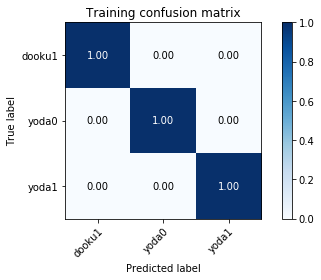

Normalized confusion matrix
[[0.5  0.07 0.43]
 [0.84 0.09 0.07]
 [0.02 0.63 0.35]]


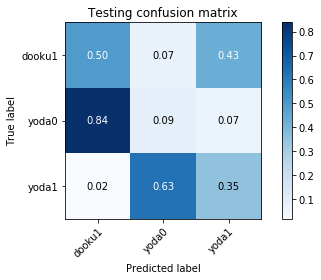

In [216]:
train_pred=LDAob.predict(PCAtrain)
test_pred=LDAob.predict(PCAtest)

classNames=np.sort(labelDat.unique())
print classNames

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = skl.metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[skl.utils.multiclass.unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(trainLabels, train_pred, classes=classNames, normalize=True,
                      title='Training confusion matrix')

plt.tight_layout()
plt.show()

plot_confusion_matrix(testLabels, test_pred, classes=classNames, normalize=True,
                      title='Testing confusion matrix')

plt.tight_layout()
plt.show()

So, from inspection of the above plots we get a little bit better idea of what is going on.

The PCA-LDA model is quite clearly separating the training set into distinct clusters.
Indeed there is little to no overlap, and its confusion matrix shows 100% accuracy. 

The testing set, on the other hand, is less clearly separated.
Just as important, however, is that the relative location of each cluster has shifted!
I.e. its as if the plot has been rotated roughly $60^{\circ}$... so if we were to try
using the PCA-LDA model as a classifier it would be putting things into the wrong class.
This is very clearly borne out in the confusion matrix. It tended to mislabel the yoda1 system
as the apo (yoda0) system. The apo (yoda0) system gets mislabeled as the dooku system,
and the dooku system gets mislabeled as the yoda1 system. A complete mess...

Fortunately, while this would yield an exceedingly poor classifier, it does still yield relatively
clear clusters visually. This is reflected in the DB score as well. In particular,
it is still a marked improvement over raw PCA (about 3 fold).

What this tells us is that the PCA mode combinations LDA picked out as being important
for separating samples of different systems into distinct clusters in the training set are still functioning to
improve separation in the testing set, even though it ends up puting the clusters in the wrong locations. 

This means we may still be able to use the coefficient information from LDA to determine which residues showed significant changes among each system... I.e. while the model may not function well as a classifier, it could still yield some useful insights.

## Estimating feature importance
Lets have a look at which PCA modes, and corresponding Phi-Psi angles LDA found important.

We will start with PCA modes.

In addition to LDA, we will also use mutual information scoring and compare results of the two.

The LDA coefficients will form an $M{\times}N$ matrix where $M$ is the number of targets and
$N$ is the number of input features (i.e. PCA modes).
These coefficients define a linear combination of features for each system... so, the higher
greater the magnitude of the coefficient is for a given feature, the more impact that feature will
have. Thus, we can use the sum of the coefficient magnitudes from each system to get an estimate
of how important a given LDA input feature was. (we could use other norms for that matter, e.g. euclidean, L1, etc)

Lets have a visual look at the results, plotting $|c_i|$ vs $i$ for each system (where $c_i$ is the coefficient
of PCA mode $i$)

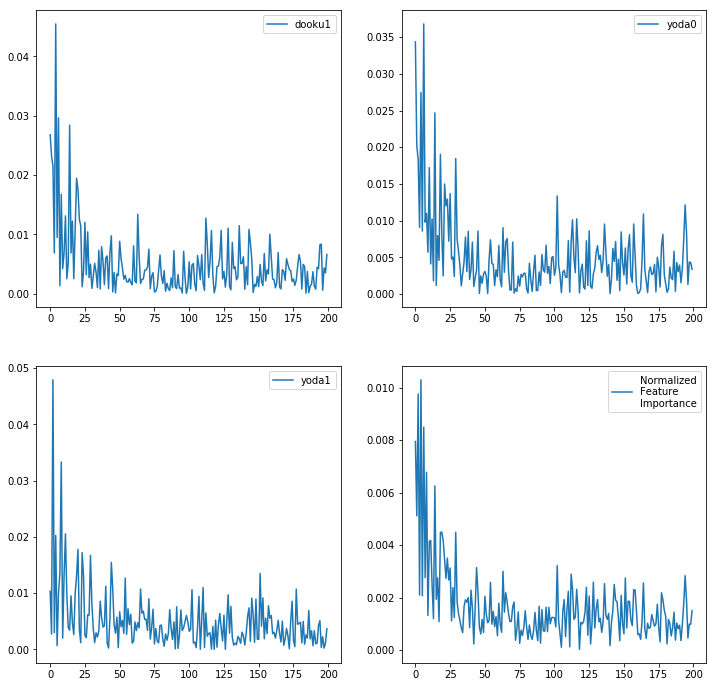

In [233]:
classLabels=np.sort(np.unique(trainLabels))

nPlots=len(classLabels)+1
nPlotRows=int(np.ceil(np.sqrt(nPlots)))
nPlotCols=int(np.ceil(1.*nPlots/nPlotRows))

fig,axs=plt.subplots(nPlotRows,nPlotCols)
fig.set_figwidth(12)
fig.set_figheight(2+10*nPlotCols/nPlotRows)
#ymax=np.max(np.abs(LDAob.coef_)/np.sum(np.abs(LDAob.coef_)))
for iClassLabel,classLabel in enumerate(classLabels):
    ax=axs.flat[iClassLabel]
    ax.plot(np.abs(LDAob.coef_[iClassLabel])/\
            np.sum(np.abs(LDAob.coef_[iClassLabel])),
             label=classLabel)
    #ax.set_ylim(0,ymax)
    ax.legend()
ax=axs.flat[-1]
ax.plot(np.mean(np.abs(LDAob.coef_),axis=0)/\
        np.sum(np.abs(LDAob.coef_)),
        label="Normalized\nFeature\nImportance")
ax.legend()
plt.show()

Now lets compare this normed LDA feature importance estimate to the mutual information
based estimate.
Peaks have been marked with red dots

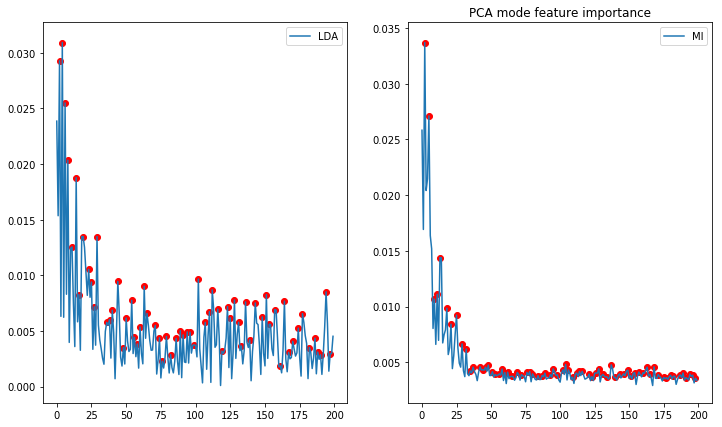

In [259]:
LDAscores=np.mean(np.abs(LDAob.coef_),axis=0)/\
        np.sum(np.abs(LDAob.coef_))
LDAscores=LDAscores/np.sum(LDAscores)
MIscores=skl.feature_selection.mutual_info_classif(PCAtrain,trainLabels)
MIscores=MIscores/np.sum(MIscores)

LDApeak_inds=sp.signal.find_peaks(LDAscores)[0]
MIpeak_inds=sp.signal.find_peaks(MIscores)[0]

fig,axs=plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(7)

ax=axs.flat[0]
ax.plot(LDAscores,label="LDA")
ax.scatter(LDApeak_inds,LDAscores[LDApeak_inds],
           c='r')
ax.legend()
ax=axs.flat[1]
ax.plot(MIscores,label="MI")
ax.scatter(MIpeak_inds,MIscores[MIpeak_inds],
           c='r')
ax.legend()
plt.title("PCA mode feature importance")
plt.show()

Visually, the two profiles look quite similar... this is not entirely surprising since
the PCA modes describe monotonically decreasing amounts of sample variance.
Lets have a look at the top 10 most important modes identified by each method.
We will also look a plot of importance vs rank for each method as well.

Top 10 PCA modes (LDA)
   PCA_mode  Importance  Rank
0         4    0.030909     0
1         2    0.029273     1
2         6    0.025480     2
3         0    0.023850     3
4         8    0.020336     4
5        14    0.018777     5
6         1    0.015348     6
7        19    0.013481     7
8        29    0.013477     8
9        18    0.013471     9
Top 10 PCA modes (MI)
   PCA_mode  Importance  Rank
0         2    0.033697     0
1         5    0.027111     1
2         0    0.025827     2
3         4    0.021469     3
4         3    0.020416     4
5         1    0.016920     5
6         6    0.016374     6
7         7    0.015179     7
8        13    0.014403     8
9        14    0.014368     9


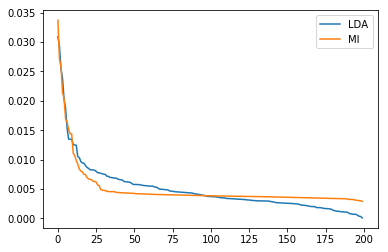

In [262]:
nTop=10

LDAscore_sort=np.argsort(-LDAscores)
LDAscoreTab=pd.DataFrame({
        'PCA_mode':np.arange(len(LDAscores))[LDAscore_sort],
        'Importance':LDAscores[LDAscore_sort],
        'Rank':np.arange(len(LDAscores))
    },columns=["PCA_mode","Importance","Rank"])
print "Top %g PCA modes (LDA)"%nTop
print LDAscoreTab.head(nTop)

MIscore_sort=np.argsort(-MIscores)
MIscoreTab=pd.DataFrame({
        'PCA_mode':np.arange(len(MIscores))[MIscore_sort],
        'Importance':MIscores[MIscore_sort],
        'Rank':np.arange(len(MIscores))
    },columns=["PCA_mode","Importance","Rank"])
print "Top %g PCA modes (MI)"%nTop
print MIscoreTab.head(nTop)

plt.plot(LDAscoreTab['Importance'],
         label='LDA')
plt.plot(MIscoreTab['Importance'],
         label='MI')
plt.legend()
plt.show()

One interesting point is that the MI score seems to plateau more significantly than
the LDA score. After roughly 25 to 30 modes, MI has pleateaued while LDA continues
to decrease monotonically (albeit at a much shallower slope than its initial decline).

One question that might be asked is if we could get similar (or perhaps even better) results
if we used fewer input PCA modes... indeed according to MI, we should only need about 25
modes before we hit diminishing returns.

Lets see if we can find the number of modes which will optimize our test score.

In [289]:
maxTop=PCAtrain.shape[1]

#print '%10s %10s %10s'%("nPCAmodes","TrainScore","TestScore")
optDat=[]
confusionMats=[]
for nTop in tqdm.tqdm_notebook(np.arange(2,maxTop)):
    MItop=np.array(MIscoreTab['PCA_mode'][:nTop],dtype=int)

    OptPCAtrain=PCAtrain[:,MItop]
    OptPCAtest=PCAtest[:,MItop]

    OptLDAob=skl.discriminant_analysis.LinearDiscriminantAnalysis()
    train_OptLDA=OptLDAob.fit_transform(OptPCAtrain,trainLabels)
    test_OptLDA=OptLDAob.transform(OptPCAtest)
    #print "%10g"%nTop,
    #print "%10.4f"%scoreFun(train_OptLDA,trainLabels),
    #print "%10.4f"%scoreFun(test_OptLDA,testLabels),
    #print ''
    optDat.append([nTop,
                   scoreFun(train_OptLDA,trainLabels),
                   scoreFun(test_OptLDA,testLabels)])
    confusionMats.append([
        nTop,
        skl.metrics.confusion_matrix(
            trainLabels,
            OptLDAob.predict(OptPCAtrain)),
        skl.metrics.confusion_matrix(
            testLabels,
            OptLDAob.predict(OptPCAtest))
    ])

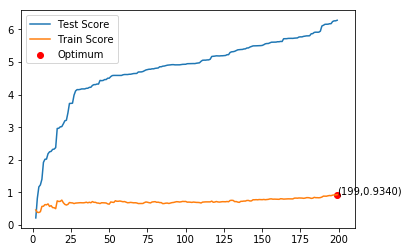

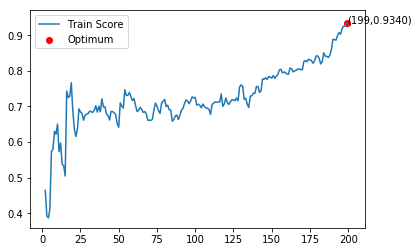

In [310]:
optDat=np.array(optDat)
plt.plot(optDat[:,0],
         (optDat[:,1]),
         label="Test Score")
plt.plot(optDat[:,0],
         (optDat[:,2]),
         label="Train Score")
optNind=np.argmax(optDat[:,2])
plt.scatter(optDat[optNind,0],
            optDat[optNind,2],
            c='r',label='Optimum')
plt.text(x=optDat[optNind,0],
         y=optDat[optNind,2],
         s="(%g,%.4f)"%(
             optDat[optNind,0],
             optDat[optNind,2]))
plt.legend()
plt.show()
plt.plot(optDat[:,0],
         (optDat[:,2]),
         label="Train Score")
optNind=np.argmax(optDat[:,2])
plt.scatter(optDat[optNind,0],
            optDat[optNind,2],
            c='r',label='Optimum')
plt.text(x=optDat[optNind,0],
         y=optDat[optNind,2],
         s="(%g,%.4f)"%(
             optDat[optNind,0],
             optDat[optNind,2]))
plt.legend()
plt.show()

So we can see that the both training and testing set show very rapid initial improvement
up to about 25 to 30 PCA modes, then a slower improvement there-after.

The above plot shows improvement with respect to cluster separation.

As before, we may also want to investigate classifier performance.

Of course, it would be hard to look at 200 pairs of confusion matrices...
fortunately, the diagonal elements of the normalized confusion matrices can serve
well here since they indicate the number of correct classifications.
So as a simple metric, we will define a loss function as one minus the mean of the diagonal
of the normalized confusion matrix.

We can the plot this for both the training and testing results.

In [299]:
def lossFun(cm):
    ncMat=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return 1.-np.mean(np.diagonal(ncMat))

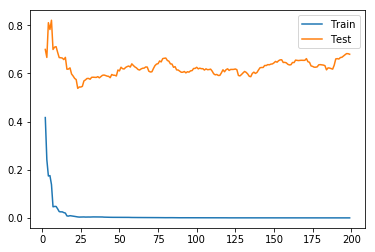

In [309]:
confusionScores=np.array(map(lambda entry: [entry[0],lossFun(entry[1]),lossFun(entry[2])],
    confusionMats))
plt.plot(confusionScores[:,0],
         confusionScores[:,1],
         label="Train")
plt.plot(confusionScores[:,0],
         confusionScores[:,2],
         label="Test")
plt.legend()
plt.show()

As expected the training data seems to converge to near perfect very rapidly.
Indeed when using 201 PCA modes, we would acheive we had a virtually perfect score
(below .005 since it dids not show up in the significant figures on the confusion matrix
plot previously).

On the other hand, the testing results faired very poorly.

We do get some useful insight here, however. The testing loss function seems to have a small
local maximum right around 25 PCA modes.

This could be a sign that we are overfitting our data.

One consideration we did not take into account is that not all of the phi-psi angles are necessarily
useful. It is possible that many may simply be contributing noise.

The next step, then, is to try to find the optimal number of phi-psi angles to use.

This is a good point to start utilizing sci kit learns pipeline and grid search utilities.

Using 'SelectKBest' coupled with mutual information for scoring, and 'gridsearchcv' we can
automate testing our PCA-LDA model with increasing numbers of phi-psi angles.

One sticking point is that using gridsearchcv, it would be hard to tune selecting the K best
phi-psi angles as well as the K best PCA modes since the total number of PCA modes generated
will never be greater than the total number of input features...

In [313]:
#Running mutuali information classification on the training data takes quite a long time.
#rather than have to re-run this each time feature selection is needed, we can precompute
#the MI scores and make a dummy function that returns that array.
#This will then be fed to 'SelectKBest'
MIscores=skl.feature_selection.mutual_info_classif(trainData,trainLabels)
MIscores[:5]

array([0.17, 0.15, 0.31, 0.2 , 0.18])

In [315]:
def tempScoreFun(X,y):
    return MIscores

Lets try this out with SelectKBest

In [321]:
tempSelect=skl.feature_selection.SelectKBest(score_func=tempScoreFun,k=25)
tempKdat=tempSelect.fit_transform(trainData,trainLabels)
print tempKdat.shape
print np.argwhere(tempSelect.get_support()).flatten()
tempKdat

(16894, 25)
[ 241  986 1228 ... 7973 8244 8297]


array([[ -22.89,  -33.23,  -45.72, ...,   87.71,  -94.49, -158.  ],
       [ -31.74,  -60.46,  -61.27, ...,   71.2 , -103.27, -141.6 ],
       [ -46.97,  -74.64,  -52.06, ...,   73.43, -105.48, -111.2 ],
       ...,
       [ -64.67,  120.68,   96.13, ...,  161.56,  -65.63, -132.47],
       [ -57.87,  127.57,  122.1 , ...,  121.62,  -51.36, -109.64],
       [ -86.16,  133.1 ,  113.74, ...,  130.43,  -59.35, -131.59]])

Since we are rather hackishly using SelectKBest, the selected features are only
correct for the particular training set that we have...
This means that when we use GridSearchCV, we need to make sure it uses our current
training and testing split.
This can be done by feeding it the appropriate list of training and testing indices.

Lets do a quick test.
For scoring, we can use the loss function from above, calculated off the 

In [324]:
def confusionMatrixScore(estimator,X,y):
    cm=skl.metrics.confusion_matrix(y,estimator.predict(X))
    ncMat=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    return np.mean(np.diagonal(ncMat))

In [328]:
print 'Original Train Score: %.5f'%confusionMatrixScore(LDAob,PCAtrain,trainLabels)
print 'Original Test Score: %.5f'%confusionMatrixScore(LDAob,PCAtest,testLabels)

Original Train Score: 0.99980
Original Test Score: 0.31334


We are almost ready, there is one sticking point to consider.
We don't know, a-priori, how many principal components to construct...
Moreover, the maximum number that can be constructed is determined by the number
of features we are using...
One option would be to simply use a fixed number every time and ensure that we
select at least that many features.
But this could lead to having to redo the process if we set the bar too high.
Moreover, the optimal number of PCA features to compute may be a function of how
many input features we have...

Fortunately, the PCA module gives a nice work around. We can specify a number
between 0 and 1 for n_components and the PCA module will then interpret this
as specifying a fixed percentage of total variance (among input features) to describe...

Of course, this is another parameter to tune.

That is on top of the fact that even after describing a set amount of variance, we still
don't know if we want just the topN components or if some lower components are actually more
important...

For now, we will pick a simple starting case.

We will scan over increasing numbers of topN features based on the precomputed MI score,
then compute enough PCA modes to describe at least 75% of their variance.

This should give us a good test of our grid search pipeline.

In [338]:
featureKset=np.array(2**np.arange(1,np.ceil(np.log2(phiPsiDat.shape[1]))),
                     dtype=int)
KbestMI_PCA_LDA_pipe=skl.pipeline.Pipeline([
    ('feature_select',skl.feature_selection.SelectKBest(score_func=tempScoreFun)),
    ('dim_reduction',skl.decomposition.PCA(n_components=.75)),
    ('classify',skl.discriminant_analysis.LinearDiscriminantAnalysis())
])
parameterGrid=[
    {
        'feature_select__k':featureKset
    }
]
gridCV=skl.model_selection.GridSearchCV(
    estimator=KbestMI_PCA_LDA_pipe,
    param_grid=parameterGrid,
    scoring=confusionMatrixScore,
    cv=[[train_indices,test_indices]])
gridCV.fit(phiPsiDat,labelDat)
mean_scores=np.array(gridCV.cv_results_['mean_test_score'])
mean_scores

array([0.5 , 0.67, 0.2 , ..., 0.4 , 0.32, 0.27])

Lets plot these results. If all goes well, we hope to find a distinct peak
which would tell us the optimal number of phi-psi angle features to include as 
well as the corresponding loss function over the testing set.

We will plot 1-score, which can serve as a loss function (it is essentially 1-accuracy)
Plotting this result for both the training and testing set may give us some instight as
to how our model fairs as a function of the number $k$ of the k-best phi-psi angles used

In [420]:
featureKset=np.array(2**np.arange(1,np.ceil(np.log2(phiPsiDat.shape[1]))),
                     dtype=int)
mean_scores=np.array(gridCV.cv_results_['mean_test_score'])
mean_train_scores=np.array(gridCV.cv_results_['mean_train_score'])

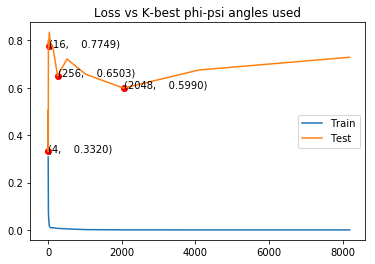

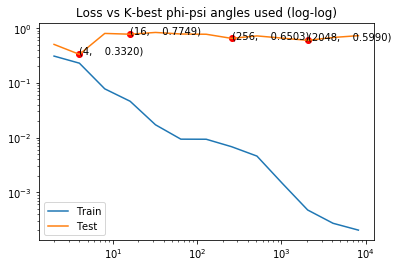

In [482]:
mean_scores=np.array(gridCV.cv_results_['mean_test_score'])
mean_train_scores=np.array(gridCV.cv_results_['mean_train_score'])

plt.plot(featureKset,1-mean_train_scores,label='Train')
plt.plot(featureKset,1-mean_scores,label='Test')

optScoreInds=sp.signal.find_peaks(mean_scores)[0]
plt.scatter(featureKset[optScoreInds],
            1-mean_scores[optScoreInds],
            c='r')
for optScoreInd in optScoreInds:
    plt.text(x=featureKset[optScoreInd],
             y=1-mean_scores[optScoreInd],
             s='(%g,%10.4f)'%(
                 featureKset[optScoreInd],
                 1-mean_scores[optScoreInd]))
plt.title('Loss vs K-best phi-psi angles used')
plt.legend()
plt.show()

plt.plot(featureKset,1-mean_train_scores,label='Train')
plt.plot(featureKset,1-mean_scores,label='Test')

optScoreInds=sp.signal.find_peaks(mean_scores)[0]
plt.scatter(featureKset[optScoreInds],
            1-mean_scores[optScoreInds],
            c='r')
for optScoreInd in optScoreInds:
    plt.text(x=featureKset[optScoreInd],
             y=1-mean_scores[optScoreInd],
             s='(%g,%10.4f)'%(
                 featureKset[optScoreInd],
                 1-mean_scores[optScoreInd]))
plt.title('Loss vs K-best phi-psi angles used (log-log)')
plt.loglog()
plt.legend()
plt.show()

So even with our best estimator, we have only about 67% accuracy...
Lets see how the clusters obtained from LDA look.

In [388]:
optTrainDat=gridCV.best_estimator_.transform(trainData)
optTestDat=gridCV.best_estimator_.transform(testData)

dooku1
yoda0
yoda1


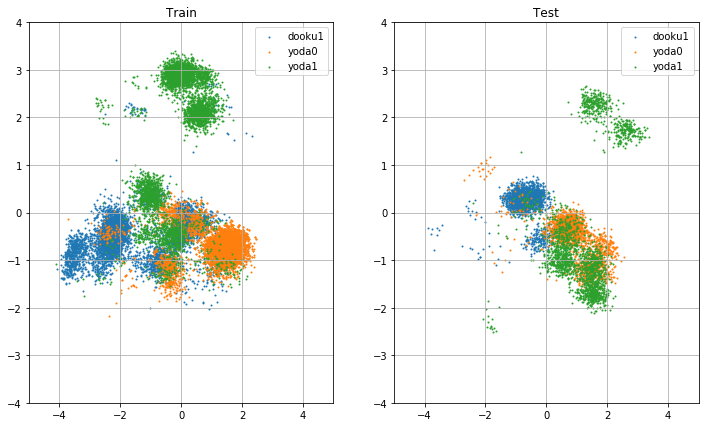

In [392]:
fig,axs=plt.subplots(1,2)

labelTypes=np.unique(labelDat)

fig.set_figwidth(12)
fig.set_figheight(7)
for labelType in labelTypes:
    print labelType
    ax=axs[0]
    labelInds=(trainLabels==labelType)
    ax.scatter(optTrainDat[labelInds,0],
               optTrainDat[labelInds,1],
               label=labelType,
               s=1)
    ax.set_title('Train')
    ax.set_xlim(-5,5)
    ax.set_ylim(-4,4)
    ax.grid()
    ax.legend()
    ax=axs[1]
    labelInds=(testLabels==labelType)
    ax.scatter(optTestDat[labelInds,0],
               optTestDat[labelInds,1],
               label=labelType,
               s=1)
    ax.set_title('Test')
    ax.set_xlim(-5,5)
    ax.set_ylim(-4,4)
    ax.grid()
    ax.legend()
plt.show()

Given that we only had 4 input angles in the best representation, we should have
relatively few principal components generated (which served as input to LDA)
Lets have a look

In [381]:
testOb=gridCV.best_estimator_.named_steps['dim_reduction']
testOb.components_

array([[-0.18,  0.18,  0.91,  0.33],
       [-0.66, -0.38, -0.27,  0.59],
       [-0.34, -0.62,  0.29, -0.65]])

It seems that we only have a total of 3 principal components.
We can visualize the PCA clusters directly using a pair of plots for
training and testing set.

--- Modes 0,1 ---
dooku1
yoda0
yoda1


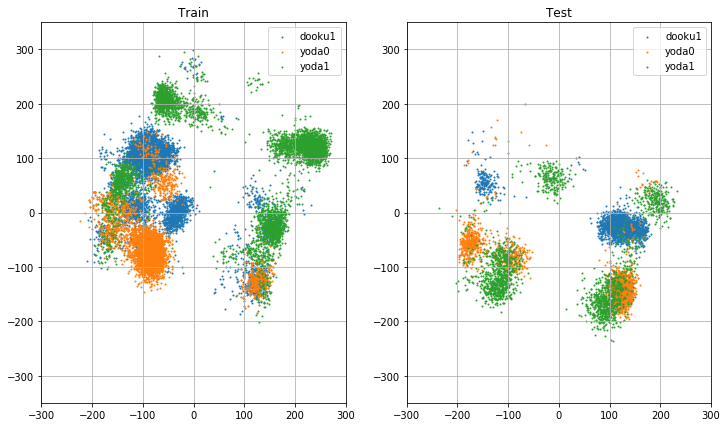

--- Modes 0,2 ---
dooku1
yoda0
yoda1


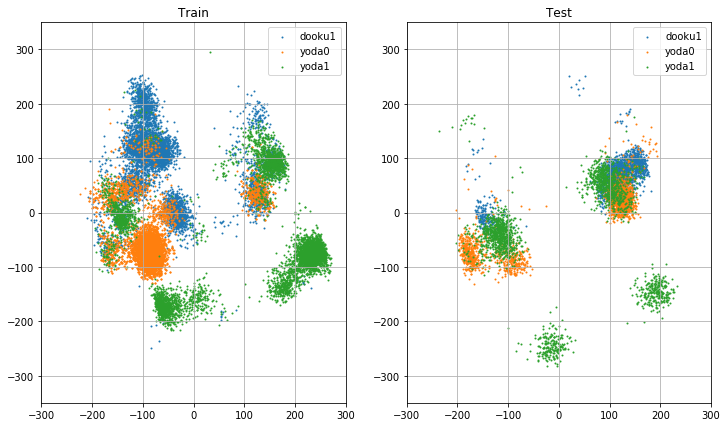

In [393]:

optTrainDat=gridCV.best_estimator_.named_steps['dim_reduction'].transform(
    gridCV.best_estimator_.named_steps['feature_select'].transform(trainData))
optTestDat=gridCV.best_estimator_.named_steps['dim_reduction'].transform(
    gridCV.best_estimator_.named_steps['feature_select'].transform(testData))

fig,axs=plt.subplots(1,2)

labelTypes=np.unique(labelDat)

fig.set_figwidth(12)
fig.set_figheight(7)
print '--- Modes 0,1 ---'
for labelType in labelTypes:
    print labelType
    ax=axs[0]
    labelInds=(trainLabels==labelType)
    ax.scatter(optTrainDat[labelInds,0],
               optTrainDat[labelInds,1],
               label=labelType,
               s=1)
    ax.set_title('Train')
    ax.set_xlim(-300,300)
    ax.set_ylim(-350,350)
    ax.grid()
    ax.legend()
    ax=axs[1]
    labelInds=(testLabels==labelType)
    ax.scatter(optTestDat[labelInds,0],
               optTestDat[labelInds,1],
               label=labelType,
               s=1)
    ax.set_title('Test')
    ax.set_xlim(-300,300)
    ax.set_ylim(-350,350)
    ax.grid()
    ax.legend()
plt.show()

fig,axs=plt.subplots(1,2)
fig.set_figwidth(12)
fig.set_figheight(7)
print '--- Modes 0,2 ---'
for labelType in labelTypes:
    print labelType
    ax=axs[0]
    labelInds=(trainLabels==labelType)
    ax.scatter(optTrainDat[labelInds,0],
               optTrainDat[labelInds,2],
               label=labelType,
               s=1)
    ax.set_title('Train')
    ax.set_xlim(-300,300)
    ax.set_ylim(-350,350)
    ax.grid()
    ax.legend()
    ax=axs[1]
    labelInds=(testLabels==labelType)
    ax.scatter(optTestDat[labelInds,0],
               optTestDat[labelInds,2],
               label=labelType,
               s=1)
    ax.set_title('Test')
    ax.set_xlim(-300,300)
    ax.set_ylim(-350,350)
    ax.grid()
    ax.legend()
plt.show()

Lastly, these phi-psi angles correspond to dihedrals between sets of backbone atoms.
We can visualize these directly on the protein structure using nglview.

Lets load a viewing structure generated in the previous step.

We will use a structure from one of the systems that contains a ligand so we can get an
idea of where the amino acid residues to which the identified angles belong are relative
to the ligand binding pocket.

In [365]:
viewStruc=pt.load('./viewingStruc.pdb')
viewStruc

pytraj.Trajectory, 1 frames: 
Size: 0.000000 (GB)
<Topology: 70325 atoms, 4255 residues, 13 mols, PBC with box type = ortho>
           

In [486]:
angleList=phiPsiDat.columns[gridCV.best_estimator_.named_steps['feature_select'].get_support()]
print angleList
resSelection=', '.join(
    [angleName.split('_')[-1] for angleName in \
     np.array(angleList,dtype=str)])
view=nv.show_pytraj(viewStruc,gui=True)
view.gui_style='ngl'
view.clear_representations()
view.add_representation('cartoon')
view.add_representation('spacefill',selection='4255')
view.add_representation('spacefill',selection=resSelection)
view

Index([u'psi_660', u'psi_794', u'psi_795', u'psi_4134'], dtype='object')


NGLWidget()

VGFiKGNoaWxkcmVuPShCb3goY2hpbGRyZW49KEJveChjaGlsZHJlbj0oQm94KGNoaWxkcmVuPShMYWJlbCh2YWx1ZT11J3N0ZXAnKSwgSW50U2xpZGVyKHZhbHVlPTEsIG1pbj0tMTAwKSksIGzigKY=
